In [128]:
import pickle
import cv2
from scipy.ndimage.measurements import label


import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import glob
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import SVC, LinearSVC
import time
%matplotlib inline
path = './cutouts/'

In [131]:
from lesson_functions import *

In [5]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Read in cars and notcars
#images = glob.glob('*.jpeg')
# images = glob.glob('./vehicles_smallset/*/*.jpeg') + glob.glob('./non-vehicles_smallset/*/*.jpeg')

vehicle_dir = '/home/sanaz/SDCND/CarND-Vehicle-Detection/vehicles/**/*.png'
non_vehicle_dir = '/home/sanaz/SDCND/CarND-Vehicle-Detection/non-vehicles/**/*.png' 

vehicle_images = glob.glob(vehicle_dir)
non_vehicle_images = glob.glob(non_vehicle_dir)
all_images = glob.glob(vehicle_dir) + glob.glob(non_vehicle_dir)

In [16]:
print ('Number of vehicle images: ' + str(len(vehicle_images)))
print ('Number of non-vehicle images: ' + str(len(non_vehicle_images)))
print ('For a total of : ' + str(len(all_images)))


Number of vehicle images: 8792
Number of non-vehicle images: 8968
For a total of : 17760


In [17]:
cars = []
notcars = []
for image in vehicle_images:
    cars.append(image)
    
for image in non_vehicle_images:
    notcars.append(image)

In [18]:
len(cars)

8792

In [19]:
len(notcars)

8968

## Explore HOG features

## Explore Color features

### prepare the feature vector

In [537]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)      

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


In [538]:
scaled_X.shape

(17760, 2580)

In [539]:
y.shape

(17760,)

2 3


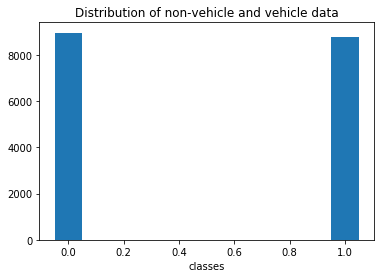

In [540]:
hist = np.histogram(y, bins = 2)
print(len(hist[0]),len(hist[1]))
plt.bar(np.array([0,1]),hist[0], width= .1)
plt.title('Distribution of non-vehicle and vehicle data')
plt.xlabel('classes')

In [541]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Number of training samples: '+str(len(X_train)))
print('Number of testing samples: '+str(len(X_test)))
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC against the test dataset
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Number of training samples: 14208
Number of testing samples: 3552
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
5.96 Seconds to train SVC...
Test Accuracy of SVC =  0.971


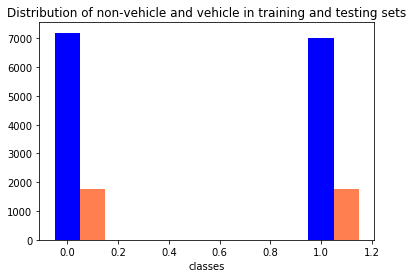

In [543]:
hist = np.histogram(y_train, bins = 2)
#print(len(hist[0]),len(hist[1]))
plt.bar(np.array([0,1]),hist[0], width= .1, color='blue')

hist = np.histogram(y_test, bins = 2)
#print(len(hist[0]),len(hist[1]))
plt.bar(np.array([0,1])+0.1,hist[0], width= .1, color='coral')

plt.title('Distribution of non-vehicle and vehicle in training and testing sets')
plt.xlabel('classes')
plt.show()

So now we have a SVM model that can be used on the frames from video.

(720, 1280, 3)


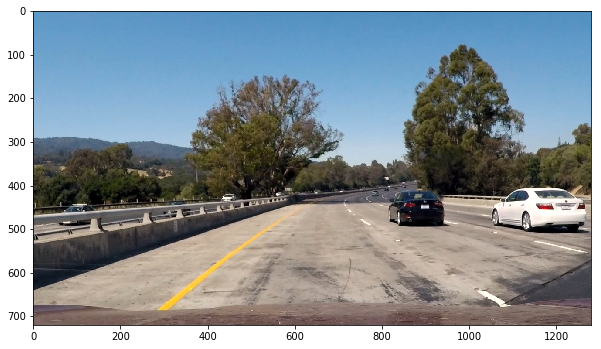

In [544]:
image = mpimg.imread('./test_images/test1.jpg')
# rescale the image so it matches the training data which was in png
image = image.astype(np.float32)/255
ready_image = np.copy(image)
plt.figure(figsize=[10,14])
plt.imshow(draw_image)
print(draw_image.shape)

## apply sliding search window on the image and use the trained SVM model to detect cars

In [337]:
#draw_image

In [556]:

def find_hot_cold_windows(ready_image):
    hot_windows_all = []
    cold_and_hot_windows = []
    for xx in [64, 96, 128]:
        yy = xx
        windows = slide_window(ready_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(xx, yy), xy_overlap=(0.7, 0.7))

        hot_windows = search_windows(ready_image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

        hot_windows_all += hot_windows
        cold_and_hot_windows += windows

    #print("number of boxes to be drawn: "+str(len(hot_windows_all)))
    return cold_and_hot_windows, hot_windows_all


In [557]:
def get_heat_maps(ready_image, cold_and_hot_windows, hot_windows_all):
    
    all_box_list = cold_and_hot_windows

    # Read in image similar to one shown above 
    hot_cold_image = ready_image.copy()#mpimg.imread('test_image.jpg')
    baseline_heat = np.ones_like(hot_cold_image[:,:,0]).astype(np.float)
    baseline_heat = add_heat(baseline_heat, all_box_list)

    
    hot_box_list = hot_windows_all
    # Read in image similar to one shown above 
    h_image = ready_image.copy()#mpimg.imread('test_image.jpg')
    heat = np.zeros_like(h_image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_box_list)
    
    return baseline_heat, heat

In [558]:
baseline_heat, hot_heat = get_heat_maps(ready_image, cold_and_hot_windows, hot_windows_all)

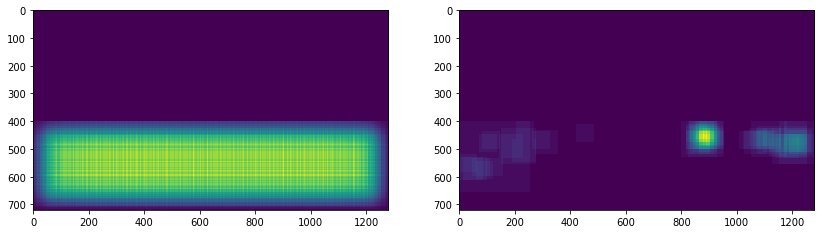

In [559]:
f, axes = plt.subplots(1,2, figsize=[14,6])
axes[0].imshow(baseline_heat)
axes[1].imshow(hot_heat)

In [560]:
def draw_hot_and_cold_windows(ready_image, cold_and_hot_windows, hot_windows_all):
    
    cold_and_hot_window_img = draw_boxes(ready_image, cold_and_hot_windows, color=(0,100,100), thick=1)        
    window_img = draw_boxes(ready_image, hot_windows_all, color=(0,100,100), thick=3)   
    
    f, axes = plt.subplots(1,2, figsize=[14,6])
    axes[0].imshow(cold_and_hot_window_img,cmap='gray')
    axes[0].set_title('All Search Windows')
    axes[1].imshow(window_img, cmap='gray')
    axes[1].set_title('Hot Search Windows') 
    

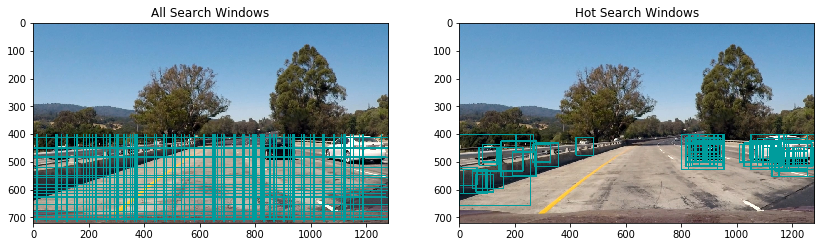

In [561]:
draw_hot_and_cold_windows(ready_image, cold_and_hot_windows, hot_windows_all)

In [576]:
def threshold_heatmap(ready_image, baseline_heat, hot_heat):
    norm_heat = hot_heat / baseline_heat
    tsh = 0.1#norm_heat.mean() + 3*norm_heat.std() #0.1
    
    heat_thresh = apply_threshold(norm_heat, tsh)
    heatmap = np.clip(heat_thresh, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    boxed_img = draw_labeled_bboxes(ready_image.copy(), labels)
    
    #out_boxed_img = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 3)
    
    return boxed_img, heatmap

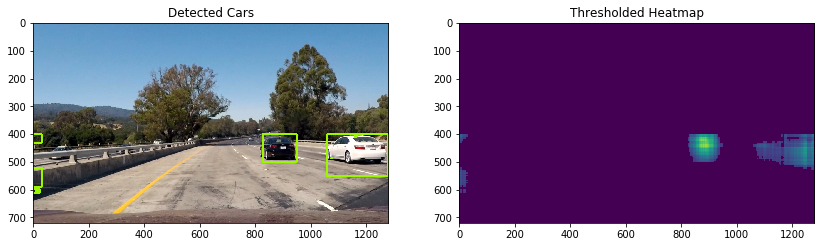

In [577]:
boxed_img, heatmap = threshold_heatmap(ready_image, baseline_heat, hot_heat)
f, axes = plt.subplots(1,2, figsize=[14,6])
axes[0].imshow(boxed_img)
axes[0].set_title('Detected Cars')
axes[1].imshow(heatmap)
axes[1].set_title('Thresholded Heatmap') 

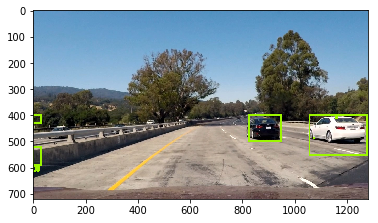

In [578]:
plt.imshow(boxed_img)

In [579]:
def entire_pipeline(input_image):
    #input_image = mpimg.imread('./test_images/test1.jpg')
    # rescale the image so it matches the training data which was in png
    input_image = input_image.astype(np.float32)/255
    ready_image = np.copy(input_image)
    
    cold_and_hot_windows, hot_windows_all = find_hot_cold_windows(ready_image)
    #draw_hot_and_cold_windows(ready_image, cold_and_hot_windows, hot_windows_all)
    
    baseline_heat, hot_heat = get_heat_maps(ready_image, cold_and_hot_windows, hot_windows_all)

    boxed_img, heatmap = threshold_heatmap(ready_image, baseline_heat, hot_heat)
    
    return boxed_img*255
    

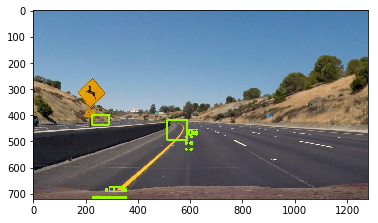

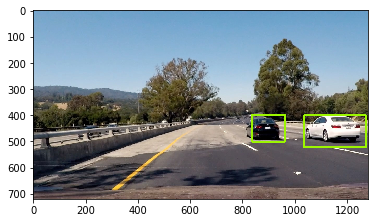

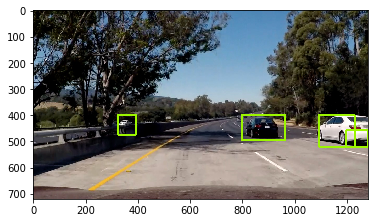

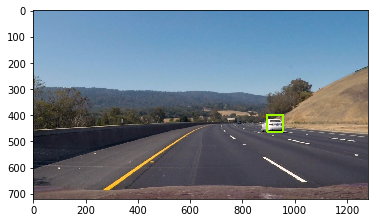

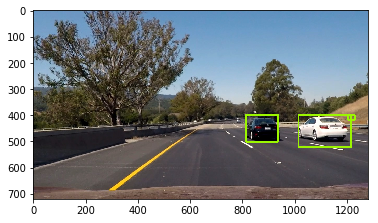

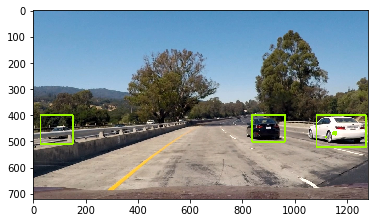

In [580]:
test_images = glob.glob('test_images/*')
for t_image in test_images:
    img = mpimg.imread(t_image)
    out = entire_pipeline(img)/255
    plt.imshow(out)
    plt.show()

In [458]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [531]:
clip_in = VideoFileClip('./project_video.mp4')
clip_small = clip_in.subclip(12,15)
#clip_out = clip_in.fl_image(entire_pipeline)
# clip_out = clip_small.fl_image(entire_pipeline)
# clip_out.write_videofile('./detecting_cars.mp4', audio=False)

In [582]:
clip_out = clip_in.fl_image(entire_pipeline)
clip_out.write_videofile('./detecting_cars.mp4', audio=False)

[MoviePy] >>>> Building video ./detecting_cars.mp4
[MoviePy] Writing video ./detecting_cars.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:02<44:48,  2.13s/it]

  0%|          | 2/1261 [00:04<44:46,  2.13s/it]

  0%|          | 3/1261 [00:06<44:42,  2.13s/it]

  0%|          | 4/1261 [00:08<44:31,  2.13s/it]

  0%|          | 5/1261 [00:10<44:26,  2.12s/it]

  0%|          | 6/1261 [00:12<44:16,  2.12s/it]

  1%|          | 7/1261 [00:14<44:10,  2.11s/it]

  1%|          | 8/1261 [00:16<44:15,  2.12s/it]

  1%|          | 9/1261 [00:19<44:17,  2.12s/it]

  1%|          | 10/1261 [00:21<44:09,  2.12s/it]

  1%|          | 11/1261 [00:23<44:04,  2.12s/it]

  1%|          | 12/1261 [00:25<43:53,  2.11s/it]

  1%|          | 13/1261 [00:27<43:42,  2.10s/it]

  1%|          | 14/1261 [00:29<43:42,  2.10s/it]

  1%|          | 15/1261 [00:31<43:40,  2.10s/it]

  1%|▏         | 16/1261 [00:33<43:42,  2.11s/it]

  1%|▏         | 17/1261 [00:35<43:44,  2.11s/it]

  1%|▏         | 18/1261 [00:38<43:37,  2.11s/it]

  2%|▏         | 19/1261 [00:40<43:31,  2.10s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./detecting_cars.mp4 



In [499]:
clip_small.write_images_sequence('./hard_frames/frame%03d.jpg')

[MoviePy] Writing frames ./hard_frames/frame%03d.jpg.

125it [00:02, 44.23it/s]             

[MoviePy]: Done writing frames ./hard_frames/frame%03d.jpg.



['./hard_frames/frame000.jpg',
 './hard_frames/frame001.jpg',
 './hard_frames/frame002.jpg',
 './hard_frames/frame003.jpg',
 './hard_frames/frame004.jpg',
 './hard_frames/frame005.jpg',
 './hard_frames/frame006.jpg',
 './hard_frames/frame007.jpg',
 './hard_frames/frame008.jpg',
 './hard_frames/frame009.jpg',
 './hard_frames/frame010.jpg',
 './hard_frames/frame011.jpg',
 './hard_frames/frame012.jpg',
 './hard_frames/frame013.jpg',
 './hard_frames/frame014.jpg',
 './hard_frames/frame015.jpg',
 './hard_frames/frame016.jpg',
 './hard_frames/frame017.jpg',
 './hard_frames/frame018.jpg',
 './hard_frames/frame019.jpg',
 './hard_frames/frame020.jpg',
 './hard_frames/frame021.jpg',
 './hard_frames/frame022.jpg',
 './hard_frames/frame023.jpg',
 './hard_frames/frame024.jpg',
 './hard_frames/frame025.jpg',
 './hard_frames/frame026.jpg',
 './hard_frames/frame027.jpg',
 './hard_frames/frame028.jpg',
 './hard_frames/frame029.jpg',
 './hard_frames/frame030.jpg',
 './hard_frames/frame031.jpg',
 './hard

In [486]:
#input_image = mpimg.imread('./test_images/test3.jpg')
#plt.imshow(entire_pipeline(input_image))

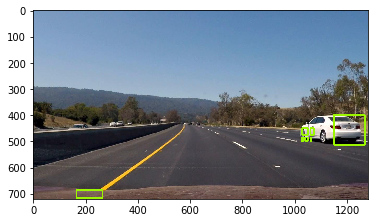

In [526]:
#input_image = mpimg.imread('./hard_frames/frame020.jpg')
#input_image/255
#entire_pipeline(input_image)
#plt.imshow(entire_pipeline(input_image))

In [520]:
#plt.imshow(cold)

In [521]:
#plt.imshow(hot)